In [6]:
import osmnx as ox

In [7]:
import geopandas as gpd
import pandas as pd
import pylab as plt
%pylab inline
import GOSTnet as gn
from make_fishnet import make_fishnet

Populating the interactive namespace from numpy and matplotlib
peartree version: 0.6.1 
networkx version: 2.3 
matplotlib version: 3.0.3 
osmnx version: 0.10 


/Users/nicholasjones/anaconda3/envs/GPD_OSM/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['plt']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [8]:
target_crs='epsg:27700'

In [9]:
G = ox.graph_from_place('Maidstone, Kent, UK')

In [193]:
G = gn.salt_long_lines(G, source = 'epsg:4326', target = target_crs, thresh = gdf2.length.min()*3)

KeyError: 'Wkt'

In [40]:
pois = ox.pois_from_place('Maidstone, Kent, UK', ['pub'])[['name','geometry']]
pois = pois[pois.geometry.geom_type == 'Point']
gdf1, gdf2 = ox.graph_to_gdfs(G)

In [11]:
coords = gdf1.total_bounds[0], gdf1.total_bounds[2], gdf1.total_bounds[1], gdf1.total_bounds[3]
make_fishnet('grid1.shp',*coords,200,200) # takes xmin, xmax, ymin, ymax

In [12]:
grid=gpd.read_file('grid1.shp')

In [13]:
grid['geometry_cpy'] = grid.geometry
grid['centroid'] = grid.geometry.centroid
grid.geometry = grid.centroid

In [14]:
# Origins
grid = gn.pandana_snap(G, grid, add_dist_to_node_col=True, target_crs='epsg:27700')

# Destinations
#pois = gn.pandana_snap(G, pois, add_dist_to_node_col=True, target_crs='epsg:27700')

/Users/nicholasjones/Desktop/code/network_analysis/GOSTnet.py:1561: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  G_tree = spatial.KDTree(node_gdf[['x','y']].as_matrix())
/Users/nicholasjones/Desktop/code/network_analysis/GOSTnet.py:1563: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  distances, indices = G_tree.query(in_df[['x','y']].as_matrix())


In [15]:
grid.geometry=grid.geometry_cpy

In [209]:
OD_matrix = gn.calculate_OD(G, list(grid.NN), list(pois.NN), np.nan, weight = 'length')

In [210]:
OD_df = pd.DataFrame(OD_matrix)

In [211]:
min_distances = OD_df.min(axis=1)

In [212]:
grid['min_dist'] = min_distances

In [213]:
grid.min_dist.replace({np.nan:grid.min_dist.max()},inplace=True)

In [214]:
grid['dist'] = grid.min_dist + grid.NN_dist

In [27]:
gdf2.columns

Index(['access', 'bridge', 'est_width', 'geometry', 'highway', 'junction',
       'key', 'lanes', 'length', 'maxspeed', 'name', 'oneway', 'osmid', 'ref',
       'service', 'tunnel', 'u', 'v', 'width'],
      dtype='object')

In [26]:
gdf1 = gdf1[['osmid','geometry']]

In [28]:
gdf2 = gdf2[['geometry', 'highway','length']]

In [41]:
#gdf1.to_file('data/MD_nodes.shp')
gdf2.to_file('data/MD_edges.shp')
pois.to_file('data/MD_pois.shp')

ValueError: Invalid field type <class 'list'>

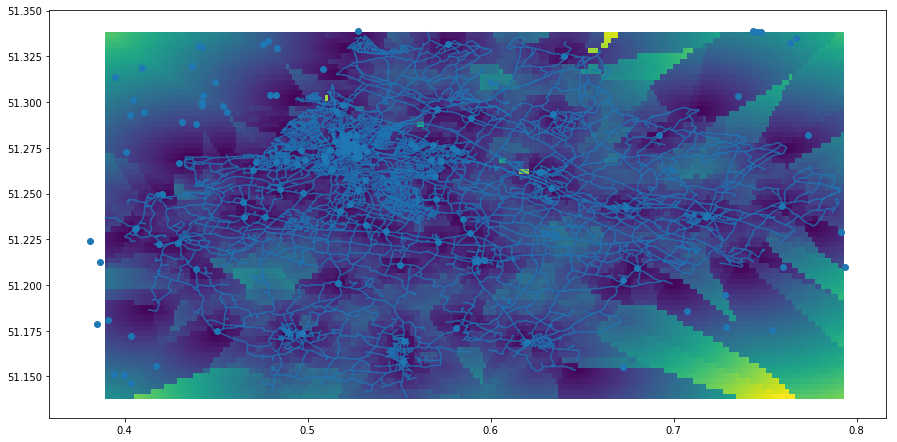

In [234]:
ax = grid.plot(column = 'dist', figsize = [15,10])
pois.plot(ax = ax)
gdf2.plot(ax = ax, alpha = 0.5)

In [230]:
pois = gpd.GeoDataFrame(pois)

AttributeError: 'Series' object has no attribute 'geometry'

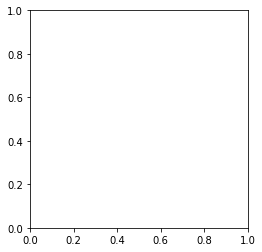

In [224]:

pois.plot()

In [197]:
grid.min_dist.describe()

count    2520.000000
mean      880.451250
std      1124.004862
min         0.000000
25%         0.000000
50%       363.554500
75%      1441.012000
max      4524.017000
Name: min_dist, dtype: float64

In [198]:
grid.NN_dist.describe()

count    2520.000000
mean     1150.843931
std      1644.163742
min         1.857324
25%       157.920040
50%       347.756013
75%      1486.777163
max      8531.247212
Name: NN_dist, dtype: float64

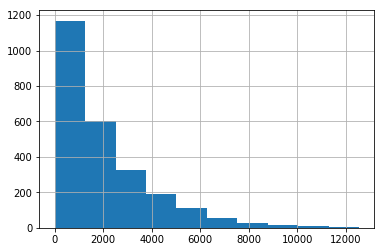

In [203]:
grid.dist.hist()